In [50]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

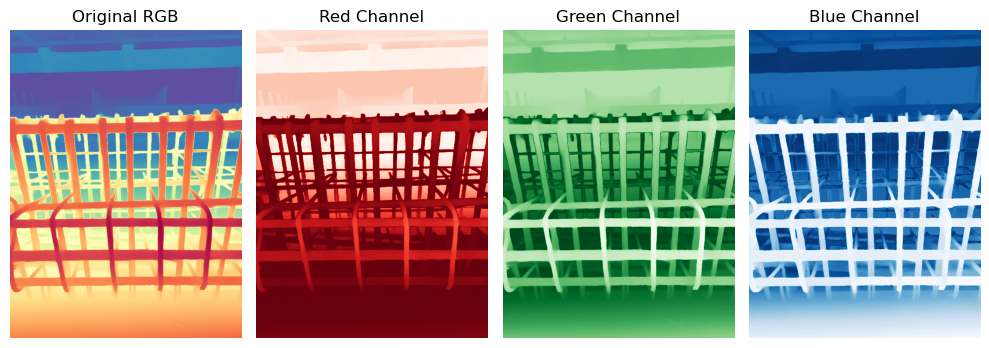

In [51]:
depth_map = cv.imread('depth_map_comparison/0.5m_pred/depth_anything_vitl/20250502_132954.png', cv.IMREAD_COLOR)
depth_map = cv.cvtColor(depth_map, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
depth_map = cv.normalize(depth_map, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

red_channel = depth_map[:,:,0]
green_channel = depth_map[:,:,1] 
blue_channel = depth_map[:,:,2]

# Let's examine which channel has the most depth variation
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(depth_map)
plt.title('Original RGB')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

In [52]:
# Replace your current find_corners function with this improved version

def find_corners(corner_image, display_image, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=50, circle_radius=20, circle_color=(255, 0, 0)):
    # Detect corners in the corner detection image
    corners = cv.goodFeaturesToTrack(
        corner_image, 
        maxCorners=maxCorners, 
        qualityLevel=qualityLevel, 
        minDistance=minDistance, 
        blockSize=blockSize
    )
    
    # Create a copy of display image to draw corners on
    result_image = display_image.copy()
    
    if corners is not None:
        corners = np.int0(corners)
        
        # Draw circles around detected corners
        for corner in corners:
            x, y = corner.ravel()
            cv.circle(result_image, (x, y), circle_radius, circle_color, -1)
        
        return result_image
    else:
        return result_image

It seems that blue has the better representation of segmenting the closer bars.  

Next steps: 
- Try to get the shape of the bar by setting a thresholds

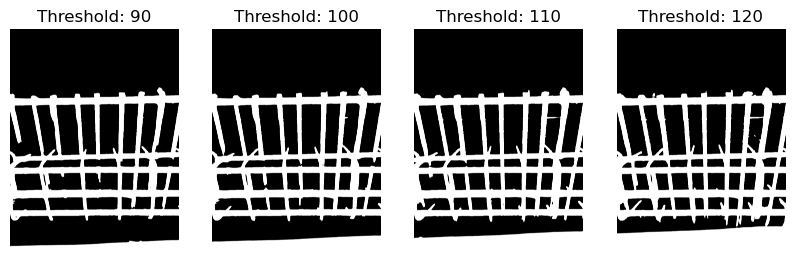

In [53]:
plt.figure(figsize=(10, 5))
thresholds = [90, 100, 110, 120]
for i in range(len(thresholds)):
    _, bar = cv.threshold(blue_channel, thresholds[i], 255, cv.THRESH_BINARY_INV)
    
    plt.subplot(1, len(thresholds), i + 1)
    plt.imshow(bar, cmap='gray')
    plt.title(f'Threshold: {thresholds[i]}')
    plt.axis('off')

I think by setting `threshold=110` captures the better representation of the bar, it shows the two layers of bar but without too many miscellaneous details.  

Next steps:
- Background Removal
- Try to segment the first and second layer.
- Set the two layers into different images

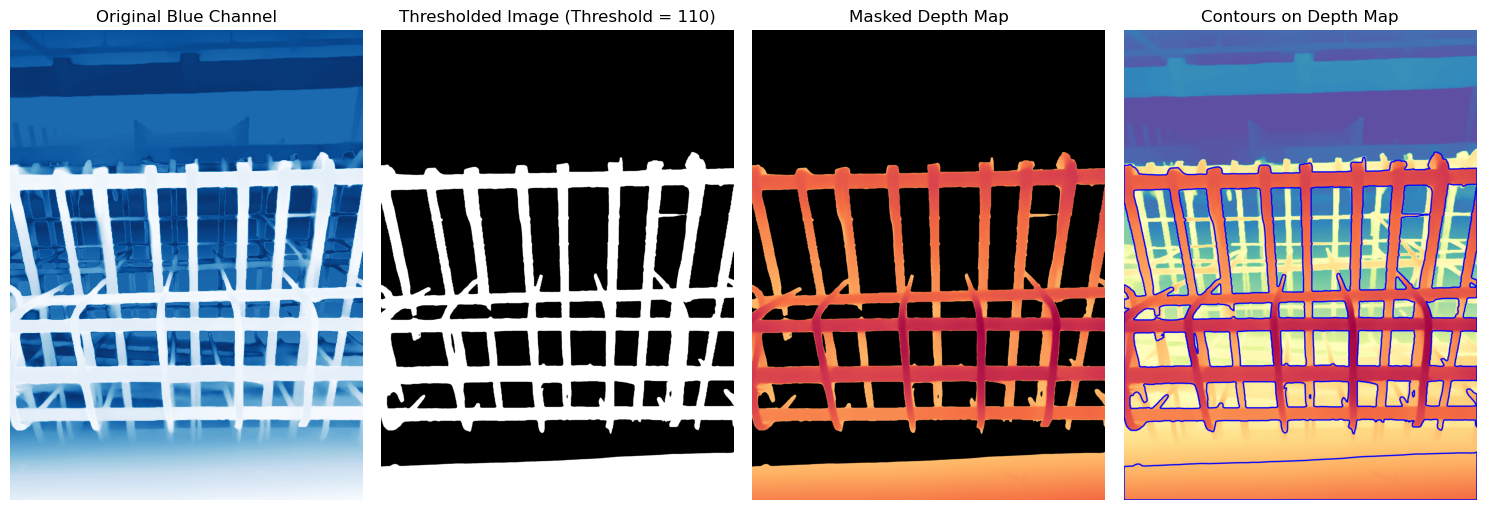

In [54]:
_, thresh = cv.threshold(blue_channel, 110, 255, cv.THRESH_BINARY_INV)
contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

depth_map_masked = cv.bitwise_and(depth_map, depth_map, mask=thresh)

depth_map_with_contours = depth_map.copy()
cv.drawContours(depth_map_with_contours, contours, -1, (0, 0, 255), 10, cv.LINE_AA)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Original Blue Channel')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image (Threshold = 110)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(depth_map_masked)
plt.title('Masked Depth Map')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(depth_map_with_contours)
plt.title('Contours on Depth Map')
plt.axis('off')

plt.tight_layout()
plt.show()

/var/folders/8r/0dvmj4y505gbvfv579p6fdxm0000gn/T/ipykernel_11805/1005586183.py:17: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


Corners Detected
🔵 First Layer  🟢 Second Layer


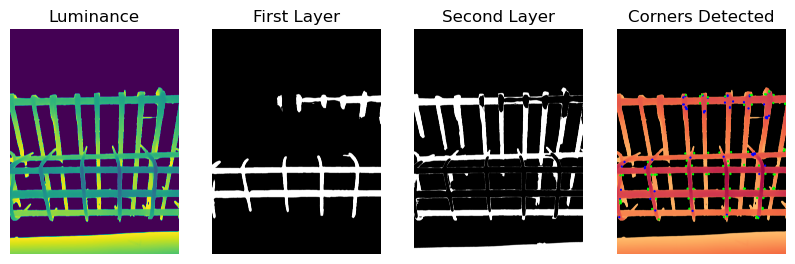

In [55]:
luminance = 0.299 * depth_map_masked[:,:,0] + 0.587 * depth_map_masked[:,:,1] + 0.114 * depth_map_masked[:,:,2]

first_layer_range = (luminance >= 25) & (luminance < 125)
first_layer = first_layer_range.astype(np.uint8) * 255
second_layer_range = (luminance >= 125) & (luminance < 175)
second_layer = second_layer_range.astype(np.uint8) * 255

display_image = find_corners(first_layer, depth_map_masked, circle_color=(0, 0, 255))
display_image = find_corners(second_layer, display_image, circle_color=(0, 255, 0))

plt.figure(figsize=(10, 5))
print('Corners Detected\n🔵 First Layer  🟢 Second Layer')

plt.subplot(1, 4, 1)
plt.imshow(luminance)
plt.title('Luminance')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(first_layer, cmap='gray')
plt.title('First Layer')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(second_layer, cmap='gray')
plt.title('Second Layer')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(display_image)
plt.title('Corners Detected')
plt.axis('off')

plt.show()

As you can see, the second layer is ugly due to the edges of the bar,  
the result is the corner detection of the second layer is on the first layer.

Next Steps:
- try to smooth out the edges using blur (https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html)
- try to use k-means as threshold (https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html)

In [56]:
def apply_blurring(image, kernel_size: tuple):
    kernel = np.ones(kernel_size, np.float32) / (kernel_size[0] * kernel_size[1])
    blurred_image = cv.filter2D(image, -1, kernel)
    return blurred_image

Method 1: segement the layers first, then apply blurring.  
Method 2: apply blurring first, then segment the layers.

/var/folders/8r/0dvmj4y505gbvfv579p6fdxm0000gn/T/ipykernel_11805/1005586183.py:17: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


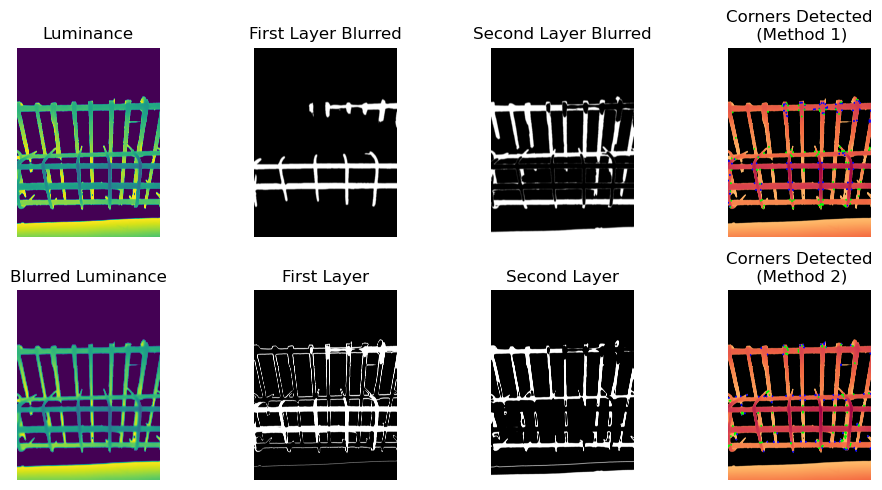

In [ ]:
# Method 1
first_layer_range = (luminance >= 25) & (luminance < 125)
first_layer = first_layer_range.astype(np.uint8) * 255
second_layer_range = (luminance >= 125) & (luminance < 175)
second_layer = second_layer_range.astype(np.uint8) * 255

first_layer_blurred = apply_blurring(first_layer, (25, 25))
second_layer_blurred = apply_blurring(second_layer, (25, 25))

method1 = find_corners(first_layer_blurred, depth_map_masked, circle_color=(0, 0, 255))
method1 = find_corners(second_layer_blurred, method1, circle_color=(0, 255, 0))

plt.figure(figsize=(10, 5))
print('Corners Detected\n🔵 First Layer  🟢 Second Layer')

# Display Method 1
plt.subplot(2, 4, 1)
plt.imshow(luminance)
plt.title('Luminance')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(first_layer_blurred, cmap='gray')
plt.title('First Layer Blurred')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(second_layer_blurred, cmap='gray')
plt.title('Second Layer Blurred')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(method1)
plt.title('Corners Detected\n (Method 1)')
plt.axis('off') 

# Method 2
depth_map_blurred = apply_blurring(luminance, (50, 50))
depth_map_blurred = cv.bitwise_and(depth_map_blurred, depth_map_blurred, mask=thresh) # Trim the excess

first_layer_range = (depth_map_blurred >= 25) & (depth_map_blurred < 125)
first_layer = first_layer_range.astype(np.uint8) * 255
second_layer_range = (depth_map_blurred >= 125) & (depth_map_blurred < 175)
second_layer = second_layer_range.astype(np.uint8) * 255

method2 = find_corners(first_layer, depth_map_masked, circle_color=(0, 0, 255))
method2 = find_corners(second_layer, method2, circle_color=(0, 255, 0))

plt.subplot(2, 4, 5)
plt.imshow(depth_map_blurred)
plt.title('Blurred Luminance')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(first_layer, cmap='gray')
plt.title('First Layer')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(second_layer, cmap='gray')
plt.title('Second Layer')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(method2)
plt.title('Corners Detected\n (Method 2)')
plt.axis('off')

plt.tight_layout()
plt.show()

blur the depth map first, and then segment the layers

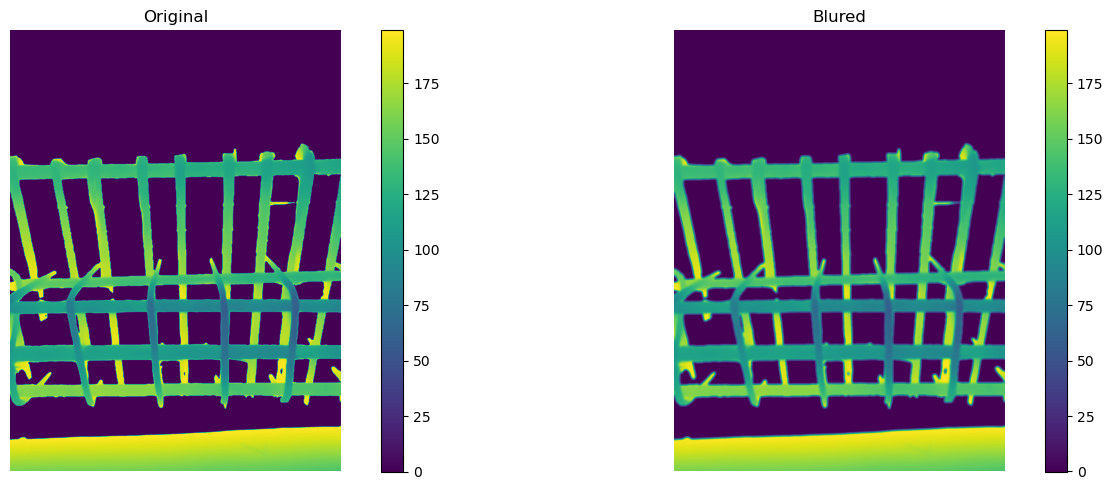

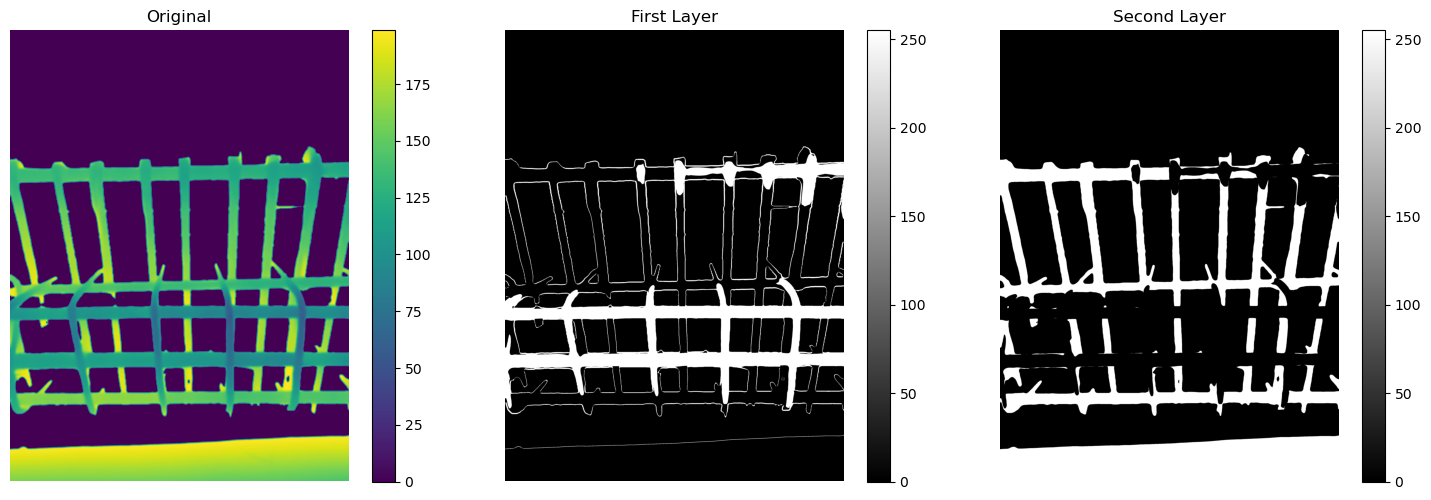

In [24]:
# apply blur
depth_map_blurred = apply_blurring(luminance, (25, 25))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(luminance)
plt.title('Original')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth_map_blurred)
plt.title('Blured')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


# segment the two layers
depth_map_blurred = cv.bitwise_and(depth_map_blurred, depth_map_blurred, mask=thresh) # trim the excess

plt.figure(figsize=(15, 5))
ncols = 3

plt.subplot(1, ncols, 1)
plt.imshow(depth_map_blurred)
plt.title('Original')
plt.colorbar()
plt.axis('off')

first_layer_range = (depth_map_blurred >= 25) & (depth_map_blurred < 125)
first_layer = first_layer_range.astype(np.uint8) * 255
plt.subplot(1, ncols, 2)
plt.imshow(first_layer, cmap='gray')
plt.title('First Layer')
plt.colorbar()
plt.axis('off')

second_layer_range = (depth_map_blurred >= 125) & (depth_map_blurred < 225)
second_layer = second_layer_range.astype(np.uint8) * 255
plt.subplot(1, ncols, 3)
plt.imshow(second_layer, cmap='gray')
plt.title('Second Layer')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


/var/folders/8r/0dvmj4y505gbvfv579p6fdxm0000gn/T/ipykernel_11805/1027186986.py:14: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


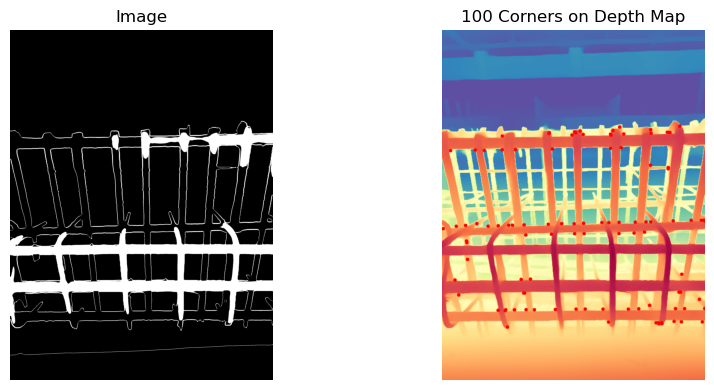

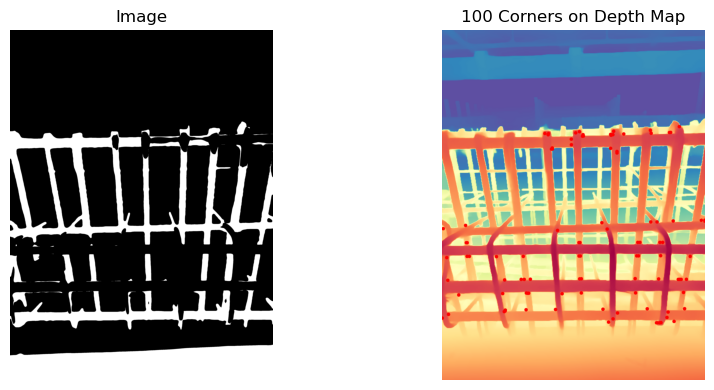

array([[[ 63, 117, 180],
        [ 63, 117, 180],
        [ 63, 117, 180],
        ...,
        [ 71, 108, 175],
        [ 71, 108, 175],
        [ 73, 105, 174]],

       [[ 63, 117, 180],
        [ 63, 117, 180],
        [ 63, 117, 180],
        ...,
        [ 71, 108, 175],
        [ 71, 108, 175],
        [ 71, 108, 175]],

       [[ 63, 117, 180],
        [ 63, 117, 180],
        [ 63, 117, 180],
        ...,
        [ 71, 108, 175],
        [ 71, 108, 175],
        [ 71, 108, 175]],

       ...,

       [[248, 131,  77],
        [248, 131,  77],
        [248, 131,  77],
        ...,
        [243, 107,  67],
        [243, 107,  67],
        [243, 107,  67]],

       [[248, 131,  77],
        [248, 131,  77],
        [248, 131,  77],
        ...,
        [243, 107,  67],
        [243, 107,  67],
        [243, 107,  67]],

       [[248, 131,  77],
        [248, 131,  77],
        [248, 131,  77],
        ...,
        [243, 107,  67],
        [243, 107,  67],
        [243, 107,  67]]

In [25]:
find_corners(first_layer)
find_corners(second_layer)

segment the layers first, and then blur the layers

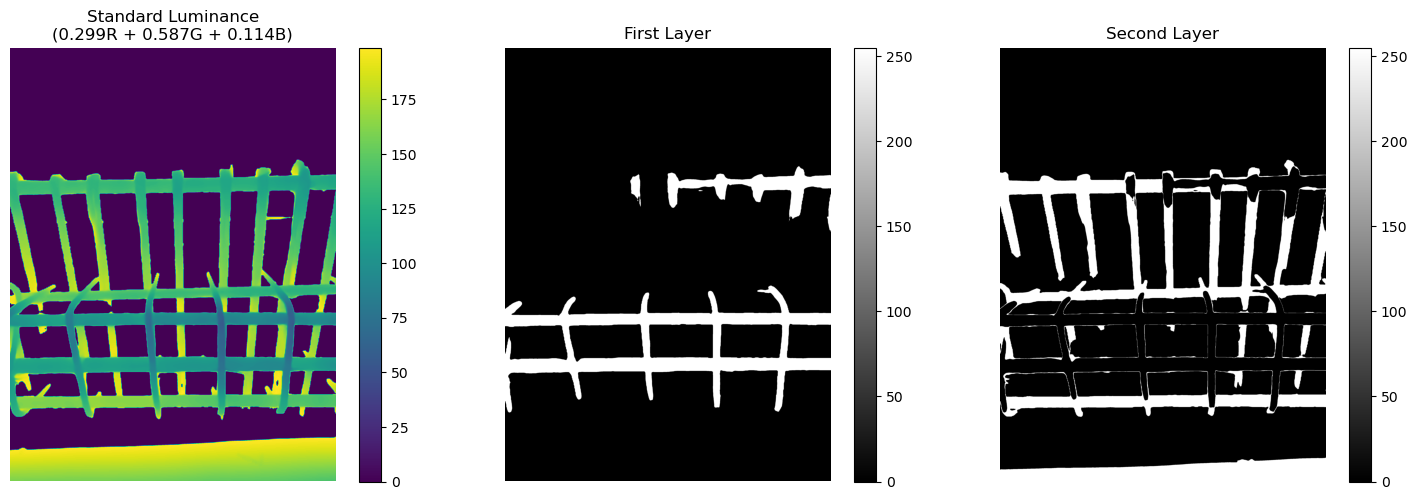

In [27]:
plt.figure(figsize=(15, 5))
ncols = 3

plt.subplot(1, ncols, 1)
plt.imshow(luminance)
plt.title('Standard Luminance\n(0.299R + 0.587G + 0.114B)')
plt.colorbar()
plt.axis('off')

first_layer_range = (luminance >= 25) & (luminance < 125)
first_layer = first_layer_range.astype(np.uint8) * 255
plt.subplot(1, ncols, 2)
plt.imshow(first_layer, cmap='gray')
plt.title('First Layer')
plt.colorbar()
plt.axis('off')

second_layer_range = (luminance >= 125) & (luminance < 175)
second_layer = second_layer_range.astype(np.uint8) * 255
plt.subplot(1, ncols, 3)
plt.imshow(second_layer, cmap='gray')
plt.title('Second Layer')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

/var/folders/8r/0dvmj4y505gbvfv579p6fdxm0000gn/T/ipykernel_11805/1027186986.py:14: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


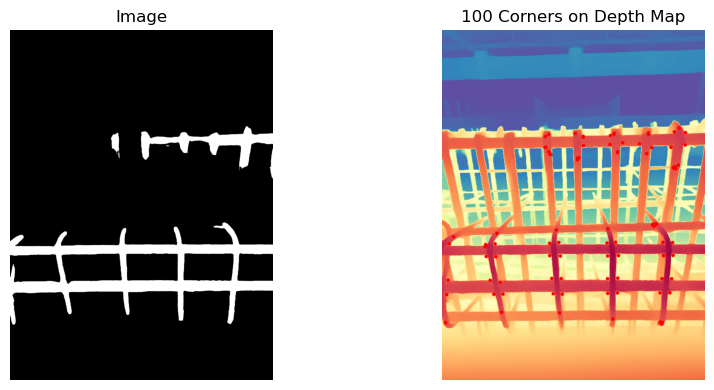

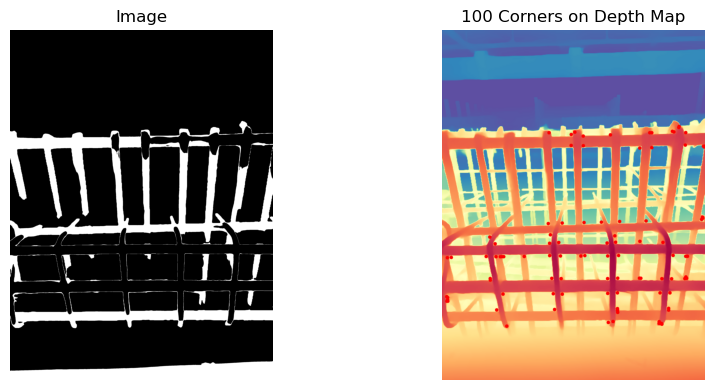

array([[[ 63, 117, 180],
        [ 63, 117, 180],
        [ 63, 117, 180],
        ...,
        [ 71, 108, 175],
        [ 71, 108, 175],
        [ 73, 105, 174]],

       [[ 63, 117, 180],
        [ 63, 117, 180],
        [ 63, 117, 180],
        ...,
        [ 71, 108, 175],
        [ 71, 108, 175],
        [ 71, 108, 175]],

       [[ 63, 117, 180],
        [ 63, 117, 180],
        [ 63, 117, 180],
        ...,
        [ 71, 108, 175],
        [ 71, 108, 175],
        [ 71, 108, 175]],

       ...,

       [[248, 131,  77],
        [248, 131,  77],
        [248, 131,  77],
        ...,
        [243, 107,  67],
        [243, 107,  67],
        [243, 107,  67]],

       [[248, 131,  77],
        [248, 131,  77],
        [248, 131,  77],
        ...,
        [243, 107,  67],
        [243, 107,  67],
        [243, 107,  67]],

       [[248, 131,  77],
        [248, 131,  77],
        [248, 131,  77],
        ...,
        [243, 107,  67],
        [243, 107,  67],
        [243, 107,  67]]

In [28]:
find_corners(first_layer)
find_corners(second_layer)

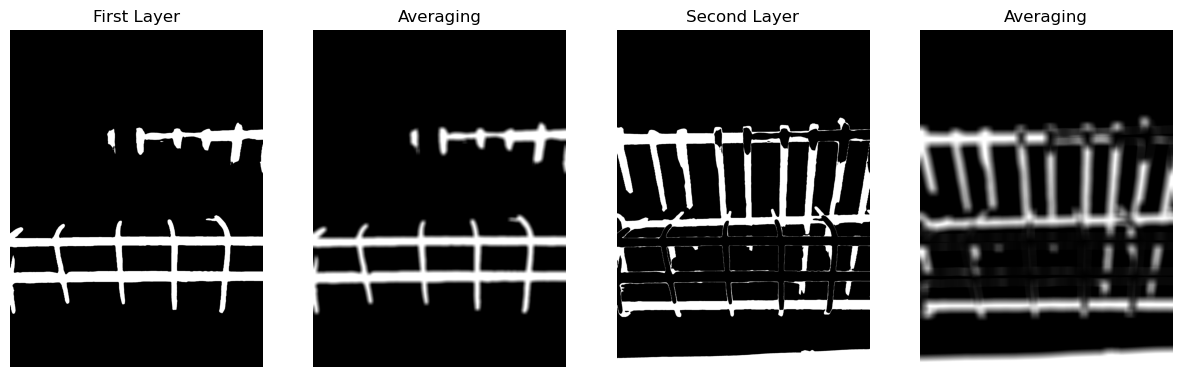

In [20]:
first_layer_blurred = apply_blurring(first_layer, (50, 50))


plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(first_layer, cmap='gray'),plt.title('First Layer')
plt.axis('off')

plt.subplot(1, 4, 2),plt.imshow(first_layer_blurred, cmap='gray'),plt.title('Averaging')
plt.axis('off')


second_layer_blurred = apply_blurring(second_layer, (100, 100))

plt.subplot(1, 4, 3)
plt.imshow(second_layer, cmap='gray'),plt.title('Second Layer')
plt.axis('off')

plt.subplot(1, 4, 4),plt.imshow(second_layer_blurred, cmap='gray'),plt.title('Averaging')
plt.axis('off')

plt.tight_layout
plt.show()

/var/folders/8r/0dvmj4y505gbvfv579p6fdxm0000gn/T/ipykernel_11805/1027186986.py:14: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


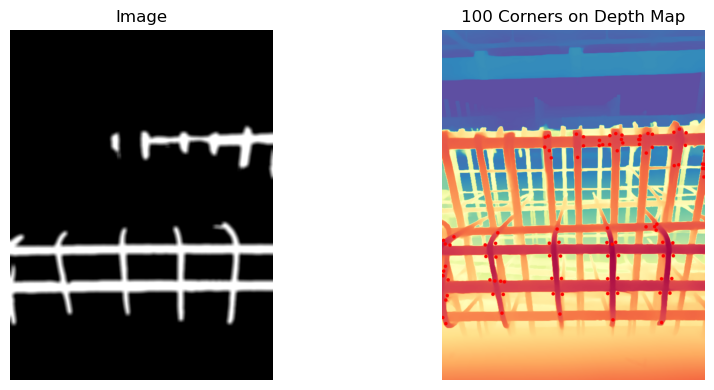

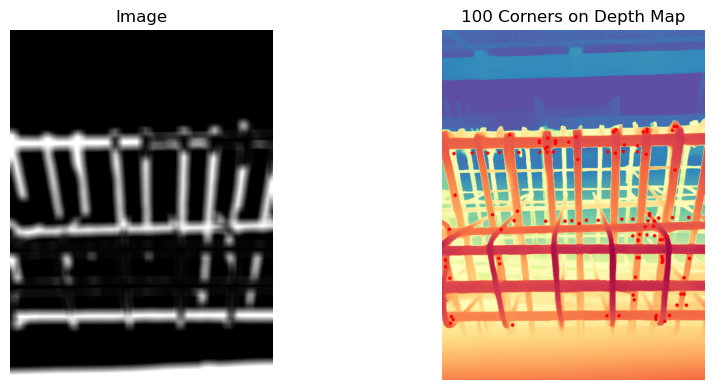

array([[[ 63, 117, 180],
        [ 63, 117, 180],
        [ 63, 117, 180],
        ...,
        [ 71, 108, 175],
        [ 71, 108, 175],
        [ 73, 105, 174]],

       [[ 63, 117, 180],
        [ 63, 117, 180],
        [ 63, 117, 180],
        ...,
        [ 71, 108, 175],
        [ 71, 108, 175],
        [ 71, 108, 175]],

       [[ 63, 117, 180],
        [ 63, 117, 180],
        [ 63, 117, 180],
        ...,
        [ 71, 108, 175],
        [ 71, 108, 175],
        [ 71, 108, 175]],

       ...,

       [[248, 131,  77],
        [248, 131,  77],
        [248, 131,  77],
        ...,
        [243, 107,  67],
        [243, 107,  67],
        [243, 107,  67]],

       [[248, 131,  77],
        [248, 131,  77],
        [248, 131,  77],
        ...,
        [243, 107,  67],
        [243, 107,  67],
        [243, 107,  67]],

       [[248, 131,  77],
        [248, 131,  77],
        [248, 131,  77],
        ...,
        [243, 107,  67],
        [243, 107,  67],
        [243, 107,  67]]

In [21]:
find_corners(first_layer_blurred)
find_corners(second_layer_blurred)

It seems that the first method(blur first) perform better on the second layer,  
and the second method(segment first) perform better on the first layer. 